In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd

In [40]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy import Column, Integer, String, Float

In [42]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [47]:
#Find column names for tabls
inspector = inspect(engine)

measurement_column = inspector.get_columns("measurement")
for m in measurement_column:
    print(m['name'], m['type'])
    
print('---------------------------------------------')

station_column = inspector.get_columns("station")
for s in station_column:
    print(s['name'], s['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [60]:
# Calculate the date 1 year ago from the last data point in the database
ordered_measurement = session.query(Measurement.prcp, Measurement.date).\
order_by(Measurement.date.desc()).session.query(Measurement.date).\
order_by(Measurement.date.desc()).first()
print(ordered_measurement)

('2017-08-23',)


In [61]:
# Design a query to retrieve the last 12 months of precipitation data 
precip_list = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()
print(precip_list[:10])

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0)]


In [95]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(precip_list)
df_precip.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [73]:
# Sort the dataframe by date
df_precip = df_precip.set_index('date')

In [79]:
# Rename the column
df_precip.rename(columns = {'prcp': 'precipitation'}, inplace=True)
df_precip.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


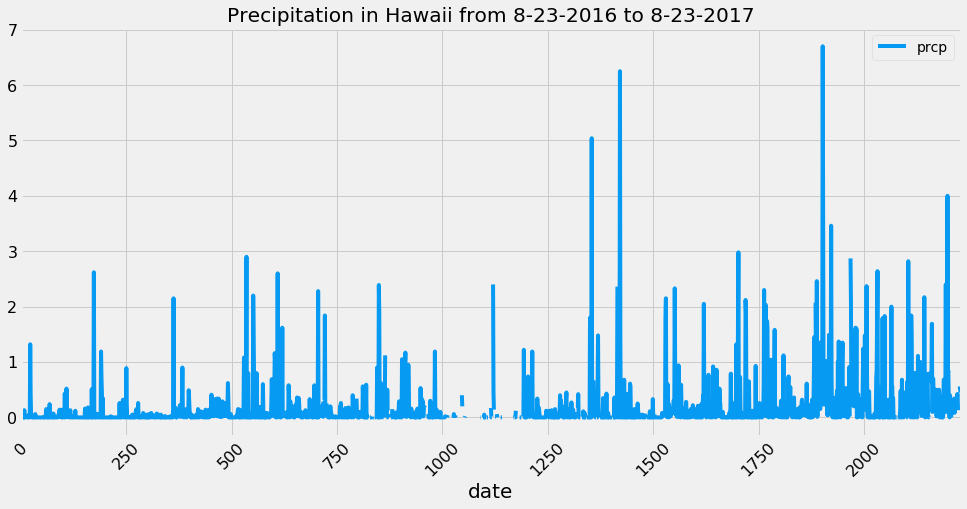

In [120]:
# Use Pandas Plotting with Matplotlib to plot the data
df_precip.plot(figsize=(15, 7),
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-23-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('date', fontsize=20)
plt.savefig("PrecipitationInHawaii.png")
plt.show()

In [87]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).count()
print(f"there are {number_stations} active stations")

there are 9 active stations


In [100]:
# The most active stations
# List the stations and the counts in descending order.
active_station_res = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station_res

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [113]:
best_station = active_station_res[0][0]
temp_results = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == best_station).\
filter(Measurement.date >= "2016-08-23").all() 
df_tobs= pd.DataFrame(temp_results)
df_tobs.set_index('station', inplace=True) 
df_tobs.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

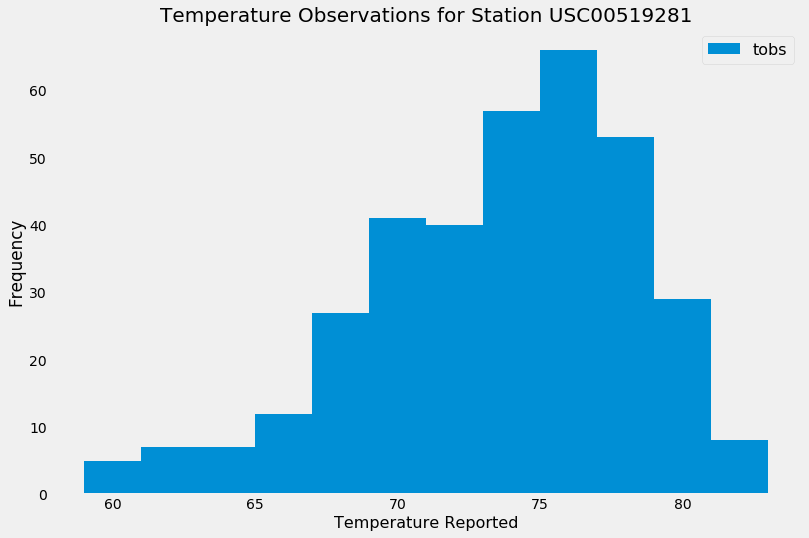

In [114]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperature Observations for Station " + best_station, fontsize=20) 
plt.xlabel("Temperature Reported", fontsize=16) 
plt.legend(bbox_to_anchor=(1,1), fontsize=16) 
plt.savefig("StationTemps.png")
plt.show

In [115]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [116]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_res = calc_temps('2012-02-28', '2012-03-05')
my_trip_res

[(62.0, 69.57142857142857, 74.0)]

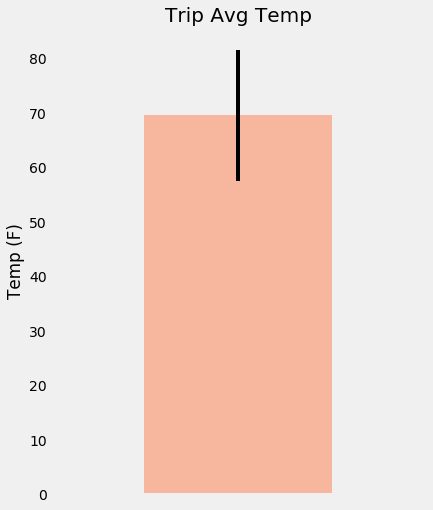

In [119]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_trip = pd.DataFrame(my_trip_res, columns=['Min Temp', 'Avg Temp', 'Max Temp']) 
avg_temp = df_trip['Avg Temp']
min_max_temp = df_trip.iloc[0]['Max Temp'] - df_trip.iloc[0]['Min Temp'] 
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral') 
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [121]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
